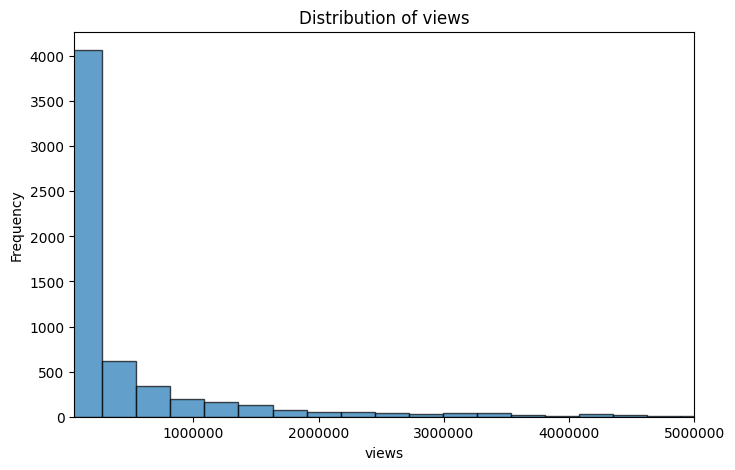

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd 

CSV_PATH   = "youtube_titles_thumbs_all_queries.csv"

df = pd.read_csv(CSV_PATH)
bins = 10

data = df['views'].dropna()   

plt.figure(figsize=(8, 5))
plt.xlim(50000, 5000000)   
plt.hist(data, bins=1000, edgecolor="black", alpha=0.7)
plt.ticklabel_format(style="plain", axis="x")
plt.title("Distribution of views")
plt.xlabel("views")
plt.ylabel("Frequency")
plt.show()



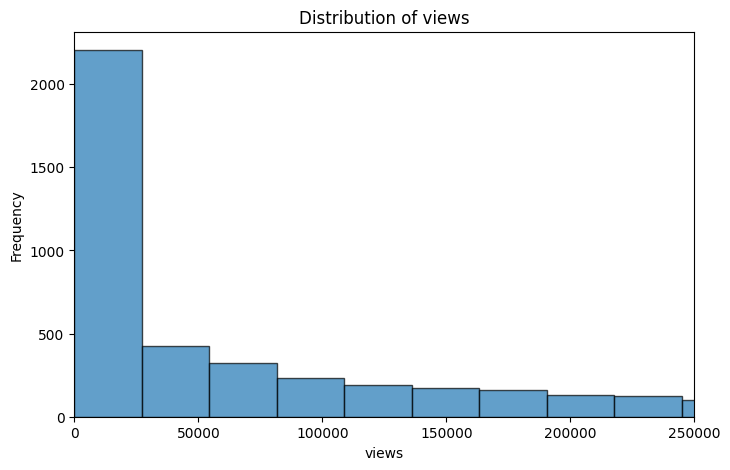

In [ ]:
import matplotlib.pyplot as plt
    

CSV_PATH   = "youtube_titles_thumbs_all_queries.csv"

df = pd.read_csv(CSV_PATH)
data = df['views'].dropna()   

plt.figure(figsize=(8, 5))
plt.xlim(0, 250000)   
plt.hist(data, bins=10000, edgecolor="black", alpha=0.7)
plt.ticklabel_format(style="plain", axis="x")
plt.title("Distribution of views")
plt.xlabel("views")
plt.ylabel("Frequency")
plt.show()



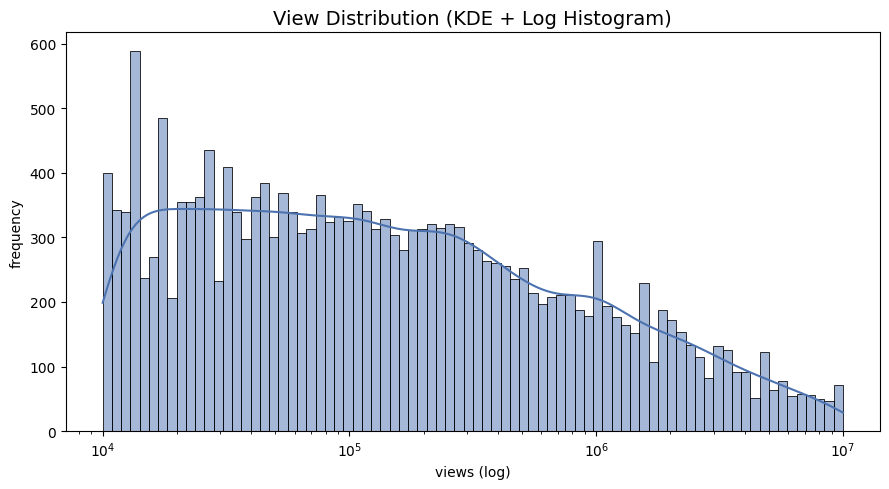

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt

data = df["views"].dropna()

plt.figure(figsize=(9,5))
sns.histplot(data, bins=80, kde=True, color="#4C72B0", log_scale=True)
plt.title("View Distribution (KDE + Log Histogram)", fontsize=14)
plt.xlabel("views (log)")
plt.ylabel("frequency")
plt.tight_layout()
plt.show()


## MODEL 1 - fine tuned clip + mlp regressor head + log10 scale

Using device: mps
Loaded 19681 filtered rows from youtube_titles_thumbs_travel_queries.csv

Log1p(views) stats AFTER filtering:
count   19681
mean        5
std         1
min         4
25%         5
50%         5
75%         6
max         7
Name: views, dtype: float64

Train: 15744, Val: 3937

Train usable samples: 14764
Val   usable samples: 3680


Epoch 1/10 [Val]: 100%|██████████| 230/230 [00:49<00:00,  4.66it/s]


Epoch 1/10 | Train MSE (log10 views): 0.5376 | Val MSE: 0.3279


Epoch 2/10 [Val]: 100%|██████████| 230/230 [00:46<00:00,  4.90it/s]


Epoch 2/10 | Train MSE (log10 views): 0.3044 | Val MSE: 0.3049


Epoch 3/10 [Val]: 100%|██████████| 230/230 [00:46<00:00,  4.90it/s]


Epoch 3/10 | Train MSE (log10 views): 0.2423 | Val MSE: 0.3305


Epoch 4/10 [Val]: 100%|██████████| 230/230 [00:46<00:00,  4.90it/s]


Epoch 4/10 | Train MSE (log10 views): 0.1823 | Val MSE: 0.3888


Epoch 5/10 [Val]: 100%|██████████| 230/230 [00:46<00:00,  4.90it/s]


Epoch 5/10 | Train MSE (log10 views): 0.1387 | Val MSE: 0.3761


Epoch 6/10 [Val]: 100%|██████████| 230/230 [00:46<00:00,  4.89it/s]


Epoch 6/10 | Train MSE (log10 views): 0.1025 | Val MSE: 0.3326


Epoch 7/10 [Val]: 100%|██████████| 230/230 [00:46<00:00,  4.90it/s]


Epoch 7/10 | Train MSE (log10 views): 0.0839 | Val MSE: 0.3341


Epoch 8/10 [Val]: 100%|██████████| 230/230 [00:48<00:00,  4.75it/s]


Epoch 8/10 | Train MSE (log10 views): 0.0744 | Val MSE: 0.3297


Epoch 9/10 [Val]: 100%|██████████| 230/230 [00:49<00:00,  4.64it/s]


Epoch 9/10 | Train MSE (log10 views): 0.0683 | Val MSE: 0.3288


Epoch 10/10 [Val]: 100%|██████████| 230/230 [00:49<00:00,  4.61it/s]


Epoch 10/10 | Train MSE (log10 views): 0.0647 | Val MSE: 0.3432

Saved model → clip_finetuned_youtube_virality.pt

Running Predicted vs Actual on validation set...


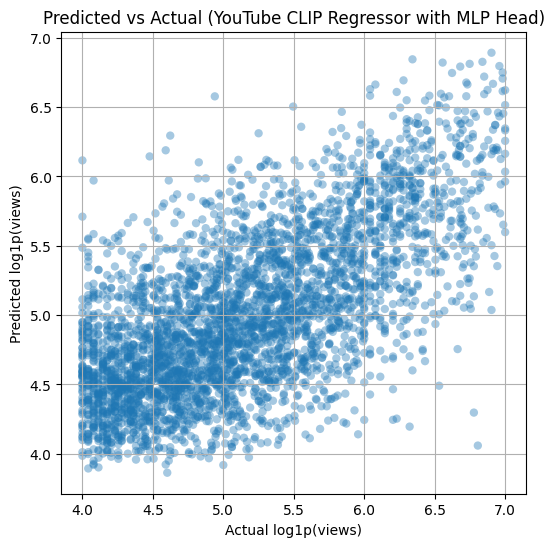


Sample predictions (first 20):
01. Actual: 5.727 | Pred: 5.416
02. Actual: 5.907 | Pred: 5.410
03. Actual: 5.560 | Pred: 5.768
04. Actual: 6.000 | Pred: 5.739
05. Actual: 5.013 | Pred: 4.695
06. Actual: 4.230 | Pred: 4.541
07. Actual: 4.763 | Pred: 5.080
08. Actual: 5.534 | Pred: 5.231
09. Actual: 5.858 | Pred: 5.443
10. Actual: 6.681 | Pred: 6.793
11. Actual: 6.826 | Pred: 6.137
12. Actual: 4.079 | Pred: 4.507
13. Actual: 4.813 | Pred: 5.004
14. Actual: 4.954 | Pred: 4.935
15. Actual: 4.519 | Pred: 4.592
16. Actual: 4.643 | Pred: 4.875
17. Actual: 4.531 | Pred: 4.732
18. Actual: 4.756 | Pred: 4.667
19. Actual: 6.000 | Pred: 5.966
20. Actual: 5.292 | Pred: 4.996


In [ ]:
#clip last two layers unfrozen + mlp head + log10 scale

import os
import math
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from transformers import CLIPModel, CLIPProcessor
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt


# config
CSV_PATH   = "youtube_titles_thumbs_travel_queries.csv"
IMG_DIR    = "thumbnails_travel"
LABEL_COL  = "views"           
OUTPUT_MODEL_PATH = "clip_finetuned_youtube_virality.pt"

BATCH_SIZE = 16
EPOCHS     = 10
LR         = 1e-4
VAL_SPLIT  = 0.2



class YouTubeDataset(Dataset):
    """
    Converts a pandas DataFrame row into model-ready tensors for CLIP

    - pixel_values: 3 x 224 x 224 float tensor (normalized RGB image for CLIP)
    - input_ids: token IDs for the title text (subword tokens, padded to length 77)
    - attention_mask: 1 where there is a real token, 0 where there is padding
    - label: single float = log10(views)
    """

    def __init__(self, df, processor, img_dir, label_col="views"):
        # keep rows with video_id, title, and label
        df = df.dropna(subset=["video_id", "title", label_col])

        df["image_path"] = df["video_id"].astype(str).apply(
            lambda vid: os.path.join(img_dir, f"{vid}.jpg")
        )

        df = df[df["image_path"].apply(os.path.exists)]

        self.df = df.reset_index(drop=True)
        self.processor = processor
        self.label_col = label_col
        self.img_dir = img_dir

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # image
        try:
            image = Image.open(row["image_path"]).convert("RGB")
        except Exception:
            # fallback black image if something is broken
            image = Image.new("RGB", (224, 224), color="black")

        # text
        title = row["title"]
        if not isinstance(title, str) or not title.strip():
            title = "YouTube video"

        # label: log10(views) 
        y_raw = float(row[self.label_col])
        y = math.log10(y_raw)

        inputs = self.processor(
            images=image,
            text=title,
            return_tensors="pt",
            padding="max_length",
            max_length=77,   # CLIP text encoder context length
            truncation=True,
        )

        return {
            "pixel_values": inputs["pixel_values"].squeeze(0),
            "input_ids": inputs["input_ids"].squeeze(0),
            "attention_mask": inputs["attention_mask"].squeeze(0),
            "label": torch.tensor(y, dtype=torch.float32),
        }


class CLIPRegressor(nn.Module):
    """
    Wrap CLIP and add a small MLP head on top of
    [image_embeds ; text_embeds] to predict log10(views).
    """

    def __init__(self, clip_model):
        super().__init__()
        self.clip = clip_model

        # Nonlinear regression head (MLP) instead of a single Linear layer
        self.regressor = nn.Sequential(
            nn.Linear(512 + 512, 512),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(512, 64),
            nn.ReLU(),

            nn.Linear(64, 1),
        )

    def forward(self, pixel_values, input_ids, attention_mask):
        outputs = self.clip(
            pixel_values=pixel_values,
            input_ids=input_ids,
            attention_mask=attention_mask,
        )

        image_embeds = outputs.image_embeds   
        text_embeds  = outputs.text_embeds    

        combined = torch.cat((image_embeds, text_embeds), dim=-1)  

        # Normalize combined embedding for stability
        combined = nn.functional.layer_norm(combined, combined.shape[-1:])

        preds = self.regressor(combined).squeeze(-1)  
        return preds


def main():
    # device
    if torch.cuda.is_available():
        device = torch.device("cuda")
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
    print("Using device:", device)

    # load data
    df = pd.read_csv(CSV_PATH)
    df = df[(df['views'] >= 10000) & (df['views'] <= 10000000)]

    # make sure views is numeric
    df[LABEL_COL] = pd.to_numeric(df[LABEL_COL], errors="coerce")

    # filter reasonable view range
    df = df[(df[LABEL_COL] >= 10_000) & (df[LABEL_COL] <= 10_000_000)]

    # drop rows with NaNs after filtering
    df = df.dropna(subset=[LABEL_COL])
    print(f"Loaded {len(df)} filtered rows from {CSV_PATH}")

    # check on log label distribution
    log_views = df[LABEL_COL].apply(lambda x: math.log10(x))
    print("\nLog1p(views) stats AFTER filtering:")
    print(log_views.describe())

    train_df, val_df = train_test_split(df, test_size=VAL_SPLIT, random_state=42)
    print(f"\nTrain: {len(train_df)}, Val: {len(val_df)}")

    clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
    processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

    # freeze all layers first
    for p in clip_model.parameters():
        p.requires_grad = False

    # unfreeze LAST 2 transformer blocks in vision & text encoders
    for block in clip_model.vision_model.encoder.layers[-2:]:
        for p in block.parameters():
            p.requires_grad = True

    for block in clip_model.text_model.encoder.layers[-2:]:
        for p in block.parameters():
            p.requires_grad = True


    train_dataset = YouTubeDataset(train_df, processor, IMG_DIR, LABEL_COL)
    val_dataset   = YouTubeDataset(val_df,   processor, IMG_DIR, LABEL_COL)

    print(f"\nTrain usable samples: {len(train_dataset)}")
    print(f"Val   usable samples: {len(val_dataset)}")

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False)

    model = CLIPRegressor(clip_model).to(device)

    optimizer = optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=LR,
        weight_decay=1e-4,   
    )
    criterion = nn.MSELoss()

    for epoch in range(EPOCHS):
        # train
        model.train()
        train_loss_sum = 0.0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]"):
            pixel_values   = batch["pixel_values"].to(device)
            input_ids      = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels         = batch["label"].to(device)

            preds = model(pixel_values, input_ids, attention_mask)
            loss  = criterion(preds, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss_sum += loss.item() * labels.size(0)

        train_loss = train_loss_sum / len(train_dataset)

        # val(actually test)
        model.eval()
        val_loss_sum = 0.0
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]"):
                pixel_values   = batch["pixel_values"].to(device)
                input_ids      = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels         = batch["label"].to(device)

                preds = model(pixel_values, input_ids, attention_mask)
                loss  = criterion(preds, labels)
                val_loss_sum += loss.item() * labels.size(0)

        val_loss = val_loss_sum / len(val_dataset)
        print(f"Epoch {epoch+1}/{EPOCHS} | Train MSE (log10 views): {train_loss:.4f} | Val MSE: {val_loss:.4f}")

    torch.save(model.state_dict(), OUTPUT_MODEL_PATH)
    print(f"\nSaved model → {OUTPUT_MODEL_PATH}")


    print("\nRunning Predicted vs Actual on validation set...")

    model.eval()
    preds = []
    actuals = []

    with torch.no_grad():
        for batch in val_loader:
            pixel_values   = batch["pixel_values"].to(device)
            input_ids      = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels         = batch["label"].to(device)

            out = model(pixel_values, input_ids, attention_mask)

            preds.extend(out.cpu().numpy())
            actuals.extend(labels.cpu().numpy())

    # Scatter plot
    plt.figure(figsize=(6, 6))
    plt.scatter(actuals, preds, alpha=0.4, edgecolors="none")
    plt.xlabel("Actual log1p(views)")
    plt.ylabel("Predicted log1p(views)")
    plt.title("Predicted vs Actual (YouTube CLIP Regressor with MLP Head)")
    plt.grid(True)
    plt.show()

    # Print first 20 pairs
    print("\nSample predictions (first 20):")
    for i in range(min(20, len(preds))):
        print(f"{i+1:02d}. Actual: {actuals[i]:.3f} | Pred: {preds[i]:.3f}")


if __name__ == "__main__":
    main()


## MODEL 2 - fine tuned clip + mlp regressor head + log10 scale + time since upload as a feature


Using device: mps
Loaded 19681 filtered rows from youtube_titles_thumbs_travel_queries.csv

Log10(views) stats AFTER filtering:
count   19681
mean        5
std         1
min         4
25%         5
50%         5
75%         6
max         7
Name: views, dtype: float64

Train: 15744, Val: 3937


/var/folders/60/rl7jg_v94ks18f_71z92qjp40000gn/T/ipykernel_1815/2346539352.py:203: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["age_days"].fillna(med, inplace=True)



Train usable samples: 14764
Val   usable samples: 3680


Epoch 1/10 [Val]: 100%|██████████| 230/230 [00:46<00:00,  4.99it/s]


Epoch 1/10 | Train MSE (log10 views): 0.5780 | Val MSE: 0.3449


Epoch 2/10 [Val]: 100%|██████████| 230/230 [00:45<00:00,  5.00it/s]


Epoch 2/10 | Train MSE (log10 views): 0.2706 | Val MSE: 0.3063


Epoch 3/10 [Val]: 100%|██████████| 230/230 [00:45<00:00,  5.00it/s]


Epoch 3/10 | Train MSE (log10 views): 0.2089 | Val MSE: 0.2780


Epoch 4/10 [Val]: 100%|██████████| 230/230 [00:45<00:00,  5.00it/s]


Epoch 4/10 | Train MSE (log10 views): 0.1626 | Val MSE: 0.2717


Epoch 5/10 [Val]: 100%|██████████| 230/230 [00:46<00:00,  5.00it/s]


Epoch 5/10 | Train MSE (log10 views): 0.1278 | Val MSE: 0.3190


Epoch 6/10 [Val]: 100%|██████████| 230/230 [00:46<00:00,  4.99it/s]


Epoch 6/10 | Train MSE (log10 views): 0.1040 | Val MSE: 0.3082


Epoch 7/10 [Val]: 100%|██████████| 230/230 [00:46<00:00,  4.99it/s]


Epoch 7/10 | Train MSE (log10 views): 0.0871 | Val MSE: 0.2953


Epoch 8/10 [Val]: 100%|██████████| 230/230 [00:45<00:00,  5.00it/s]


Epoch 8/10 | Train MSE (log10 views): 0.0751 | Val MSE: 0.3123


Epoch 9/10 [Val]: 100%|██████████| 230/230 [00:47<00:00,  4.82it/s]


Epoch 9/10 | Train MSE (log10 views): 0.0708 | Val MSE: 0.2949


Epoch 10/10 [Val]: 100%|██████████| 230/230 [00:47<00:00,  4.89it/s]


Epoch 10/10 | Train MSE (log10 views): 0.0679 | Val MSE: 0.2918

Saved model → clip_finetuned_youtube_virality.pt

Running Predicted vs Actual on validation set...


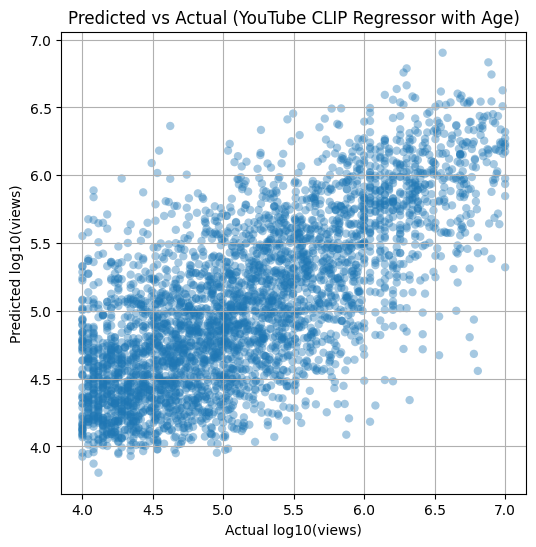


Sample predictions (first 20):
01. Actual: 5.727 | Pred: 5.925
02. Actual: 5.907 | Pred: 4.819
03. Actual: 5.560 | Pred: 5.817
04. Actual: 6.000 | Pred: 6.092
05. Actual: 5.013 | Pred: 4.794
06. Actual: 4.230 | Pred: 4.197
07. Actual: 4.763 | Pred: 4.574
08. Actual: 5.534 | Pred: 4.996
09. Actual: 5.858 | Pred: 5.714
10. Actual: 6.681 | Pred: 6.252
11. Actual: 6.826 | Pred: 6.543
12. Actual: 4.079 | Pred: 4.764
13. Actual: 4.813 | Pred: 4.891
14. Actual: 4.954 | Pred: 5.658
15. Actual: 4.519 | Pred: 4.757
16. Actual: 4.643 | Pred: 5.148
17. Actual: 4.531 | Pred: 4.639
18. Actual: 4.756 | Pred: 4.455
19. Actual: 6.000 | Pred: 5.496
20. Actual: 5.292 | Pred: 5.445


In [ ]:
#adding the video age-time since upload


import os
import math
import re
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from transformers import CLIPModel, CLIPProcessor
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt


CSV_PATH   = "youtube_titles_thumbs_travel_queries.csv"
IMG_DIR    = "thumbnails_travel"
LABEL_COL  = "views"            # change if your column is named differently
OUTPUT_MODEL_PATH = "clip_finetuned_youtube_virality.pt"

BATCH_SIZE = 16
EPOCHS     = 10
LR         = 1e-4
VAL_SPLIT  = 0.2


def parse_relative_age(text):
    """
    Convert strings like '12 hours ago', '3 days ago', '2 weeks ago',
    '1 month ago', '2 years ago' into approximate age in DAYS
    """
    if not isinstance(text, str):
        return None

    t = text.lower()

    m = re.search(r"(\d+)", t)
    if not m:
        return None
    value = int(m.group(1))

    if "hour" in t:
        return value / 24.0
    if "day" in t:
        return float(value)
    if "week" in t:
        return float(value * 7)
    if "month" in t:
        return float(value * 30)
    if "year" in t:
        return float(value * 365)

    return None


class YouTubeDataset(Dataset):
    """
    Converts a pandas DataFrame row into model-ready tensors for CLIP.

    - pixel_values: 3 x 224 x 224 float tensor (normalized RGB image for CLIP)
    - input_ids: token IDs for the title text (subword tokens, padded to length 77)
    - attention_mask: 1 where there is a real token, 0 where there is padding
    - label: single float = log10(views)
    - age: single float = normalized video age in days
    """

    def __init__(self, df, processor, img_dir, label_col="views"):
        # keep rows with video_id, title, label, and age
        df = df.dropna(subset=["video_id", "title", label_col, "age_days_norm"])

        df["image_path"] = df["video_id"].astype(str).apply(
            lambda vid: os.path.join(img_dir, f"{vid}.jpg")
        )

        # only keep rows where the image file actually exists
        df = df[df["image_path"].apply(os.path.exists)]

        self.df = df.reset_index(drop=True)
        self.processor = processor
        self.label_col = label_col
        self.img_dir = img_dir

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # image
        try:
            image = Image.open(row["image_path"]).convert("RGB")
        except Exception:
            image = Image.new("RGB", (224, 224), color="black")

        # text
        title = row["title"]
        if not isinstance(title, str) or not title.strip():
            title = "YouTube video"

        # label: log10(views)
        y_raw = float(row[self.label_col])
        y = math.log10(y_raw)

        # normalized age feature
        age = float(row["age_days_norm"])

        inputs = self.processor(
            images=image,
            text=title,
            return_tensors="pt",
            padding="max_length",
            max_length=77,   # CLIP text encoder context length
            truncation=True,
        )

        return {
            "pixel_values": inputs["pixel_values"].squeeze(0),
            "input_ids": inputs["input_ids"].squeeze(0),
            "attention_mask": inputs["attention_mask"].squeeze(0),
            "label": torch.tensor(y, dtype=torch.float32),
            "age": torch.tensor(age, dtype=torch.float32),
        }


class CLIPRegressor(nn.Module):
    """
    Wrap CLIP and add a small MLP head on top of
    [image_embeds ; text_embeds ; age] to predict log10(views).
    """

    def __init__(self, clip_model):
        super().__init__()
        self.clip = clip_model

        # Nonlinear regression head (MLP)
        # 512 (image) + 512 (text) + 1 (age) = 1025
        self.regressor = nn.Sequential(
            nn.Linear(512 + 512 + 1, 512),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(512, 64),
            nn.ReLU(),

            nn.Linear(64, 1),
        )

    def forward(self, pixel_values, input_ids, attention_mask, age):
        outputs = self.clip(
            pixel_values=pixel_values,
            input_ids=input_ids,
            attention_mask=attention_mask,
        )

        image_embeds = outputs.image_embeds   # [B, 512]
        text_embeds  = outputs.text_embeds    # [B, 512]

     
        age = age.unsqueeze(1)
        combined = torch.cat((image_embeds, text_embeds, age), dim=-1)  # [B, 1025]
        combined = nn.functional.layer_norm(combined, combined.shape[-1:])

        preds = self.regressor(combined).squeeze(-1)  # [B]
        return preds


def main():
    # device
    if torch.cuda.is_available():
        device = torch.device("cuda")
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
    print("Using device:", device)

    # load data
    df = pd.read_csv(CSV_PATH)

    # initial view filter 
    df = df[(df["views"] >= 10_000) & (df["views"] <= 10_000_000)]

    # make sure views is numeric
    df[LABEL_COL] = pd.to_numeric(df[LABEL_COL], errors="coerce")

    # filter reasonable view range again (kept as in your code)
    df = df[(df[LABEL_COL] >= 10_000) & (df[LABEL_COL] <= 10_000_000)]

    #adding video age
    df["age_days"] = df["age_text"].apply(parse_relative_age)

    # Fill missing with median
    med = df["age_days"].median()
    df["age_days"].fillna(med, inplace=True)

    # Normalize
    mu = df["age_days"].mean()
    sigma = df["age_days"].std() if df["age_days"].std() != 0 else 1.0
    df["age_days_norm"] = (df["age_days"] - mu) / sigma


    # drop rows with NaNs after filtering
    df = df.dropna(subset=[LABEL_COL, "age_days_norm"])
    print(f"Loaded {len(df)} filtered rows from {CSV_PATH}")

    # check on log10 label distribution
    log_views = df[LABEL_COL].apply(lambda x: math.log10(x))
    print("\nLog10(views) stats AFTER filtering:")
    print(log_views.describe())

    train_df, val_df = train_test_split(df, test_size=VAL_SPLIT, random_state=42)
    print(f"\nTrain: {len(train_df)}, Val: {len(val_df)}")

    # CLIP
    clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
    processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

    for p in clip_model.parameters():
        p.requires_grad = False

    for block in clip_model.vision_model.encoder.layers[-2:]:
        for p in block.parameters():
            p.requires_grad = True

    for block in clip_model.text_model.encoder.layers[-2:]:
        for p in block.parameters():
            p.requires_grad = True

    train_dataset = YouTubeDataset(train_df, processor, IMG_DIR, LABEL_COL)
    val_dataset   = YouTubeDataset(val_df,   processor, IMG_DIR, LABEL_COL)

    print(f"\nTrain usable samples: {len(train_dataset)}")
    print(f"Val   usable samples: {len(val_dataset)}")

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False)

    model = CLIPRegressor(clip_model).to(device)
  
    optimizer = optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=LR,
        weight_decay=1e-4,   # regularization
    )
    criterion = nn.MSELoss()

    for epoch in range(EPOCHS):

        model.train()
        train_loss_sum = 0.0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]"):
            pixel_values   = batch["pixel_values"].to(device)
            input_ids      = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels         = batch["label"].to(device)
            age            = batch["age"].to(device)

            preds = model(pixel_values, input_ids, attention_mask, age)
            loss  = criterion(preds, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss_sum += loss.item() * labels.size(0)

        train_loss = train_loss_sum / len(train_dataset)


        model.eval()
        val_loss_sum = 0.0
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]"):
                pixel_values   = batch["pixel_values"].to(device)
                input_ids      = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels         = batch["label"].to(device)
                age            = batch["age"].to(device)
                summary        =batch['summary'].to(device)

                preds = model(pixel_values, input_ids, attention_mask, age)
                loss  = criterion(preds, labels)
                val_loss_sum += loss.item() * labels.size(0)

        val_loss = val_loss_sum / len(val_dataset)
        print(f"Epoch {epoch+1}/{EPOCHS} | Train MSE (log10 views): {train_loss:.4f} | Val MSE: {val_loss:.4f}")

    torch.save(model.state_dict(), OUTPUT_MODEL_PATH)
    print(f"\nSaved model → {OUTPUT_MODEL_PATH}")


    print("\nRunning Predicted vs Actual on validation set...")

    model.eval()
    preds = []
    actuals = []

    with torch.no_grad():
        for batch in val_loader:
            pixel_values   = batch["pixel_values"].to(device)
            input_ids      = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels         = batch["label"].to(device)
            age            = batch["age"].to(device)

            out = model(pixel_values, input_ids, attention_mask, age)

            preds.extend(out.cpu().numpy())
            actuals.extend(labels.cpu().numpy())

    # Scatter plot
    plt.figure(figsize=(6, 6))
    plt.scatter(actuals, preds, alpha=0.4, edgecolors="none")
    plt.xlabel("Actual log10(views)")
    plt.ylabel("Predicted log10(views)")
    plt.title("Predicted vs Actual (YouTube CLIP Regressor with Age)")
    plt.grid(True)
    plt.show()

    # Print first 20 pairs
    print("\nSample predictions (first 20):")
    for i in range(min(20, len(preds))):
        print(f"{i+1:02d}. Actual: {actuals[i]:.3f} | Pred: {preds[i]:.3f}")


if __name__ == "__main__":
    main()


## MODEL 3 - lora finetuning + mlp regressor head + time since upload

Using device: mps
Loaded 19681 filtered rows from youtube_titles_thumbs_travel_queries.csv

Log10(views) stats AFTER filtering:
count    19681.000000
mean         5.144989
std          0.750621
min          4.000000
25%          4.518514
50%          5.064458
75%          5.685742
max          7.000000
Name: views, dtype: float64

Train: 15744, Val: 3937


/var/folders/60/rl7jg_v94ks18f_71z92qjp40000gn/T/ipykernel_1736/2837114579.py:287: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["age_days"].fillna(med, inplace=True)



Train usable samples: 14764
Val   usable samples: 3680

Trainable parameters (LoRA + MLP): 1,541,249


Epoch 1/10 [Val]: 100%|██████████| 230/230 [00:49<00:00,  4.67it/s]


Epoch 1/10 | Train MSE (log10 views): 1.0738 | Val MSE: 0.3330


Epoch 2/10 [Val]: 100%|██████████| 230/230 [00:48<00:00,  4.75it/s]


Epoch 2/10 | Train MSE (log10 views): 0.2842 | Val MSE: 0.2809


Epoch 3/10 [Val]: 100%|██████████| 230/230 [00:48<00:00,  4.76it/s]


Epoch 3/10 | Train MSE (log10 views): 0.2270 | Val MSE: 0.2909


Epoch 4/10 [Val]: 100%|██████████| 230/230 [00:48<00:00,  4.75it/s]


Epoch 4/10 | Train MSE (log10 views): 0.1697 | Val MSE: 0.2903


Epoch 5/10 [Val]: 100%|██████████| 230/230 [00:49<00:00,  4.69it/s]


Epoch 5/10 | Train MSE (log10 views): 0.1183 | Val MSE: 0.3725


Epoch 6/10 [Val]: 100%|██████████| 230/230 [00:49<00:00,  4.66it/s]


Epoch 6/10 | Train MSE (log10 views): 0.0870 | Val MSE: 0.3070


Epoch 7/10 [Val]: 100%|██████████| 230/230 [00:50<00:00,  4.59it/s]


Epoch 7/10 | Train MSE (log10 views): 0.0653 | Val MSE: 0.3055


Epoch 8/10 [Val]: 100%|██████████| 230/230 [00:50<00:00,  4.56it/s]


Epoch 8/10 | Train MSE (log10 views): 0.0560 | Val MSE: 0.2988


Epoch 9/10 [Val]: 100%|██████████| 230/230 [00:50<00:00,  4.59it/s]


Epoch 9/10 | Train MSE (log10 views): 0.0501 | Val MSE: 0.3023


Epoch 10/10 [Val]: 100%|██████████| 230/230 [00:48<00:00,  4.73it/s]


Epoch 10/10 | Train MSE (log10 views): 0.0473 | Val MSE: 0.3029

Saved model → clip_finetuned_youtube_virality_custom_lora.pt

Running Predicted vs Actual on validation set...


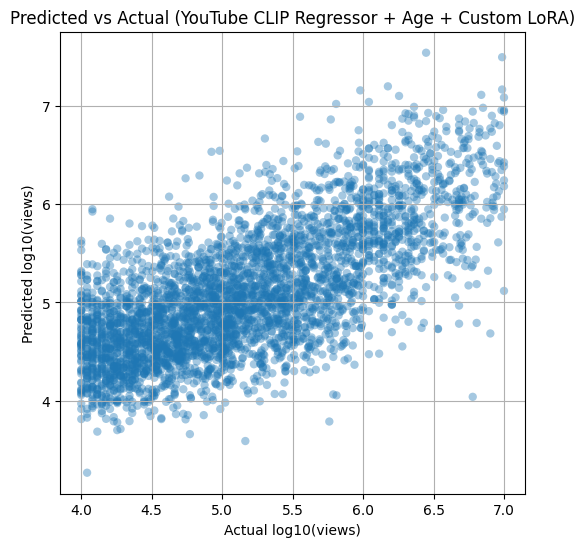


Sample predictions (first 20):
01. Actual: 5.727 | Pred: 6.307
02. Actual: 5.907 | Pred: 5.550
03. Actual: 5.560 | Pred: 5.362
04. Actual: 6.000 | Pred: 5.418
05. Actual: 5.013 | Pred: 4.645
06. Actual: 4.230 | Pred: 4.233
07. Actual: 4.763 | Pred: 4.645
08. Actual: 5.534 | Pred: 4.867
09. Actual: 5.858 | Pred: 5.854
10. Actual: 6.681 | Pred: 6.871
11. Actual: 6.826 | Pred: 6.732
12. Actual: 4.079 | Pred: 4.114
13. Actual: 4.813 | Pred: 5.087
14. Actual: 4.954 | Pred: 5.242
15. Actual: 4.519 | Pred: 4.044
16. Actual: 4.643 | Pred: 4.954
17. Actual: 4.531 | Pred: 4.354
18. Actual: 4.756 | Pred: 4.610
19. Actual: 6.000 | Pred: 5.566
20. Actual: 5.292 | Pred: 4.473


In [ ]:
# custom lora + mlp + age feature 

import os
import math
import re
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from transformers import CLIPModel, CLIPProcessor
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F



CSV_PATH   = "youtube_titles_thumbs_travel_queries.csv"
IMG_DIR    = "thumbnails_travel"
LABEL_COL  = "views"
OUTPUT_MODEL_PATH = "clip_finetuned_youtube_virality_custom_lora.pt"

BATCH_SIZE = 16
EPOCHS     = 10
LR         = 1e-4
VAL_SPLIT  = 0.2

# LoRA hyperparams
LORA_R      = 16
LORA_ALPHA  = 32
LORA_TARGET = ["q_proj", "v_proj"]  



def parse_relative_age(text):
    """
    Convert strings like '12 hours ago', '3 days ago', '2 weeks ago',
    '1 month ago', '2 years ago' into approximate age in DAYS.
    """
    if not isinstance(text, str):
        return None

    t = text.lower()

    m = re.search(r"(\d+)", t)
    if not m:
        return None
    value = int(m.group(1))

    if "hour" in t:
        return value / 24.0
    if "day" in t:
        return float(value)
    if "week" in t:
        return float(value * 7)
    if "month" in t:
        return float(value * 30)
    if "year" in t:
        return float(value * 365)

    return None


# Custom LoRA 

class LoRALinear(nn.Module):
    """
    A Linear layer with a frozen base weight + low-rank trainable update.

    y = x @ W^T + b + scaling * (x @ A^T @ B^T)

    - W, b are copied from the original nn.Linear and frozen.
    - A, B are trainable; rank r << min(in_features, out_features).
    """

    def __init__(self, base_linear: nn.Linear, r: int = 4, alpha: float = 1.0):
        super().__init__()
        assert isinstance(base_linear, nn.Linear)

        self.in_features  = base_linear.in_features
        self.out_features = base_linear.out_features
        self.r            = r

        # scaling factor 
        self.scaling = alpha / r

        # freeze original weight & bias
        self.weight = nn.Parameter(base_linear.weight.data.clone(), requires_grad=False)
        if base_linear.bias is not None:
            self.bias = nn.Parameter(base_linear.bias.data.clone(), requires_grad=False)
        else:
            self.bias = None


        self.lora_A = nn.Linear(self.in_features, r, bias=False)
        self.lora_B = nn.Linear(r, self.out_features, bias=False)

        # Initialize LoRA weights:
        nn.init.kaiming_uniform_(self.lora_A.weight, a=math.sqrt(5))
        nn.init.zeros_(self.lora_B.weight)

    def forward(self, x):

        base = F.linear(x, self.weight, self.bias)
        delta = self.lora_B(self.lora_A(x)) * self.scaling
        return base + delta


def apply_lora_to_attn_projections(module: nn.Module,
                                   target_names=None,
                                   r: int = 4,
                                   alpha: float = 1.0):
    """
    Recursively walk over `module` and replace any child whose name is in
    `target_names` and is nn.Linear with a LoRALinear wrapper.
    """
    if target_names is None:
        target_names = ["q_proj", "v_proj"]

    for name, child in list(module.named_children()):
        # If this child is one of the attention projection linears, wrap it.
        if isinstance(child, nn.Linear) and name in target_names:
            lora_layer = LoRALinear(child, r=r, alpha=alpha)
            setattr(module, name, lora_layer)
        else:
            # Recurse into child modules
            apply_lora_to_attn_projections(child, target_names, r, alpha)


def count_trainable_params(model: nn.Module):
    total = 0
    for p in model.parameters():
        if p.requires_grad:
            total += p.numel()
    return total

# ---------------- Dataset & Model ----------------

class YouTubeDataset(Dataset):
    """
    Converts a pandas DataFrame row into model-ready tensors for CLIP.

    - pixel_values: 3 x 224 x 224 float tensor (normalized RGB image for CLIP).
    - input_ids: token IDs for the title text (subword tokens, padded to length 77).
    - attention_mask: 1 where there is a real token, 0 where there is padding.
    - label: single float = log10(views).
    - age: single float = normalized video age in days.
    """

    def __init__(self, df, processor, img_dir, label_col="views"):
        df = df.dropna(subset=["video_id", "title", label_col, "age_days_norm"])

        df["image_path"] = df["video_id"].astype(str).apply(
            lambda vid: os.path.join(img_dir, f"{vid}.jpg")
        )

        df = df[df["image_path"].apply(os.path.exists)]

        self.df = df.reset_index(drop=True)
        self.processor = processor
        self.label_col = label_col
        self.img_dir = img_dir

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # image
        try:
            image = Image.open(row["image_path"]).convert("RGB")
        except Exception:
            # fallback black image if something is broken
            image = Image.new("RGB", (224, 224), color="black")

        # text
        title = row["title"]
        if not isinstance(title, str) or not title.strip():
            title = "YouTube video"

        # label: log10(views)
        y_raw = float(row[self.label_col])
        y = math.log10(y_raw)

        # normalized age feature
        age = float(row["age_days_norm"])

        inputs = self.processor(
            images=image,
            text=title,
            return_tensors="pt",
            padding="max_length",
            max_length=77,   # CLIP text encoder context length
            truncation=True,
        )

        return {
            "pixel_values": inputs["pixel_values"].squeeze(0),
            "input_ids": inputs["input_ids"].squeeze(0),
            "attention_mask": inputs["attention_mask"].squeeze(0),
            "label": torch.tensor(y, dtype=torch.float32),
            "age": torch.tensor(age, dtype=torch.float32),
        }


class CLIPRegressor(nn.Module):
    """
    Wrap CLIP and add a small MLP head on top of
    [image_embeds ; text_embeds ; age] to predict log10(views).
    """

    def __init__(self, clip_model):
        super().__init__()
        self.clip = clip_model

        # Nonlinear regression head (MLP)
        # 512 (image) + 512 (text) + 1 (age) = 1025
        self.regressor = nn.Sequential(
            nn.Linear(512 + 512 + 1, 512),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(512, 64),
            nn.ReLU(),

            nn.Linear(64, 1),
        )

    def forward(self, pixel_values, input_ids, attention_mask, age):
        outputs = self.clip(
            pixel_values=pixel_values,
            input_ids=input_ids,
            attention_mask=attention_mask,
        )

        image_embeds = outputs.image_embeds   # [B, 512]
        text_embeds  = outputs.text_embeds    # [B, 512]

        age = age.unsqueeze(1)

        combined = torch.cat((image_embeds, text_embeds, age), dim=-1)  # [B, 1025]

        # Normalize combined embedding for stability
        combined = nn.functional.layer_norm(combined, combined.shape[-1:])

        preds = self.regressor(combined).squeeze(-1)  # [B]
        return preds




def main():
    # device
    if torch.cuda.is_available():
        device = torch.device("cuda")
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
    print("Using device:", device)

    # load data
    df = pd.read_csv(CSV_PATH)

    # initial view filter
    df = df[(df["views"] >= 10_000) & (df["views"] <= 10_000_000)]

    # make sure views is numeric
    df[LABEL_COL] = pd.to_numeric(df[LABEL_COL], errors="coerce")

    df["age_days"] = df["age_text"].apply(parse_relative_age)

    med = df["age_days"].median()
    df["age_days"].fillna(med, inplace=True)

    mu = df["age_days"].mean()
    sigma = df["age_days"].std() if df["age_days"].std() != 0 else 1.0
    df["age_days_norm"] = (df["age_days"] - mu) / sigma


    df = df.dropna(subset=[LABEL_COL, "age_days_norm"])
    print(f"Loaded {len(df)} filtered rows from {CSV_PATH}")

    # quick check on log label distribution
    log_views = df[LABEL_COL].apply(lambda x: math.log10(x))
    print("\nLog10(views) stats AFTER filtering:")
    print(log_views.describe())

    train_df, val_df = train_test_split(df, test_size=VAL_SPLIT, random_state=42)
    print(f"\nTrain: {len(train_df)}, Val: {len(val_df)}")


    clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
    processor  = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

    # Freeze all original CLIP params
    for p in clip_model.parameters():
        p.requires_grad = False

    # Apply LoRA to attention projections in both text and vision towers
    apply_lora_to_attn_projections(
        clip_model.text_model,
        target_names=LORA_TARGET,
        r=LORA_R,
        alpha=LORA_ALPHA,
    )
    apply_lora_to_attn_projections(
        clip_model.vision_model,
        target_names=LORA_TARGET,
        r=LORA_R,
        alpha=LORA_ALPHA,
    )

    clip_model.to(device)



    train_dataset = YouTubeDataset(train_df, processor, IMG_DIR, LABEL_COL)
    val_dataset   = YouTubeDataset(val_df,   processor, IMG_DIR, LABEL_COL)

    print(f"\nTrain usable samples: {len(train_dataset)}")
    print(f"Val   usable samples: {len(val_dataset)}")

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False)

    model = CLIPRegressor(clip_model).to(device)

    # Only LoRA params + MLP head will have requires_grad=True
    trainable_params = count_trainable_params(model)
    print(f"\nTrainable parameters (LoRA + MLP): {trainable_params:,}")

    optimizer = optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=LR,
        weight_decay=1e-4,   
    )
    criterion = nn.MSELoss()

    for epoch in range(EPOCHS):

        #train
        model.train()
        train_loss_sum = 0.0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]"):
            pixel_values   = batch["pixel_values"].to(device)
            input_ids      = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels         = batch["label"].to(device)
            age            = batch["age"].to(device)

            preds = model(pixel_values, input_ids, attention_mask, age)
            loss  = criterion(preds, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss_sum += loss.item() * labels.size(0)

        train_loss = train_loss_sum / len(train_dataset)

        # validation 
        model.eval()
        val_loss_sum = 0.0
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]"):
                pixel_values   = batch["pixel_values"].to(device)
                input_ids      = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels         = batch["label"].to(device)
                age            = batch["age"].to(device)

                preds = model(pixel_values, input_ids, attention_mask, age)
                loss  = criterion(preds, labels)
                val_loss_sum += loss.item() * labels.size(0)

        val_loss = val_loss_sum / len(val_dataset)
        print(f"Epoch {epoch+1}/{EPOCHS} | Train MSE (log10 views): {train_loss:.4f} | Val MSE: {val_loss:.4f}")

    torch.save(model.state_dict(), OUTPUT_MODEL_PATH)
    print(f"\nSaved model → {OUTPUT_MODEL_PATH}")


    print("\nRunning Predicted vs Actual on validation set...")

    model.eval()
    preds = []
    actuals = []

    with torch.no_grad():
        for batch in val_loader:
            pixel_values   = batch["pixel_values"].to(device)
            input_ids      = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels         = batch["label"].to(device)
            age            = batch["age"].to(device)

            out = model(pixel_values, input_ids, attention_mask, age)

            preds.extend(out.cpu().numpy())
            actuals.extend(labels.cpu().numpy())

    # Scatter plot
    plt.figure(figsize=(6, 6))
    plt.scatter(actuals, preds, alpha=0.4, edgecolors="none")
    plt.xlabel("Actual log10(views)")
    plt.ylabel("Predicted log10(views)")
    plt.title("Predicted vs Actual (YouTube CLIP Regressor + Age + Custom LoRA)")
    plt.grid(True)
    plt.show()

    print("\nSample predictions (first 20):")
    for i in range(min(20, len(preds))):
        print(f"{i+1:02d}. Actual: {actuals[i]:.3f} | Pred: {preds[i]:.3f}")


if __name__ == "__main__":
    main()


In [ ]:
#loading model and trying out

import torch
import torch.nn as nn
import numpy as np
from PIL import Image
from transformers import CLIPModel, CLIPProcessor

OUTPUT_MODEL_PATH = "clip_finetuned_youtube_virality.pt"
BASE_CLIP_MODEL   = "openai/clip-vit-base-patch32"

device = torch.device(
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)
print("Using device:", device)


class CLIPRegressor(nn.Module):
    """
    Same architecture as in your training script.
    Predicts log10(views) from [image_embeds ; text_embeds ; age].
    """

    def __init__(self, clip_model):
        super().__init__()
        self.clip = clip_model

        self.regressor = nn.Sequential(
            nn.Linear(512 + 512 + 1, 512),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(512, 64),
            nn.ReLU(),

            nn.Linear(64, 1),
        )

    def forward(self, pixel_values, input_ids, attention_mask, age):
        outputs = self.clip(
            pixel_values=pixel_values,
            input_ids=input_ids,
            attention_mask=attention_mask,
        )

        image_embeds = outputs.image_embeds   
        text_embeds  = outputs.text_embeds    

        age = age.unsqueeze(1)               

        combined = torch.cat((image_embeds, text_embeds, age), dim=-1)  
        # you had this in training:
        combined = nn.functional.layer_norm(combined, combined.shape[-1:])

        preds = self.regressor(combined).squeeze(-1)  
        return preds


clip_model = CLIPModel.from_pretrained(BASE_CLIP_MODEL).to(device)
processor = CLIPProcessor.from_pretrained(BASE_CLIP_MODEL)

model = CLIPRegressor(clip_model).to(device)

state_dict = torch.load(OUTPUT_MODEL_PATH, map_location=device)
missing, unexpected = model.load_state_dict(state_dict, strict=False)
print("Missing keys:", missing)
print("Unexpected keys:", unexpected)

model.eval()


def choose_best_photo_3(photo1_path, photo2_path, photo3_path,
                        caption1, caption2, caption3,
                        model, processor):
    model.eval()

    photos = [
        (photo1_path, caption1),
        (photo2_path, caption2),
        (photo3_path, caption3),
    ]

    predictions = []
    
    for photo_path, caption in photos:
        img = Image.open(photo_path).convert('RGB')

        inputs = processor(
            images=img,
            text=caption,
            return_tensors="pt",
            padding="max_length",
            max_length=77,
            truncation=True,
        )

        pixel_values   = inputs['pixel_values'].to(device)
        input_ids      = inputs['input_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)

        age = torch.zeros(pixel_values.size(0), device=device)

        with torch.no_grad():
            pred_log10_views = model(
                pixel_values, input_ids, attention_mask, age
            ).item()

        predicted_views = 10 ** pred_log10_views

        predictions.append((photo_path, caption, predicted_views))
        print(
            f'Image:   {photo_path}\n'
            f'Caption: "{caption}"\n'
            f'→ Predicted views: {predicted_views:.2f} (log10={pred_log10_views:.3f})\n'
        )
    
    # pick best duo
    best_photo_path, best_caption, best_views = max(predictions, key=lambda x: x[2])

    print(
        "\nYou should post this duo:\n"
        f'Image:   {best_photo_path}\n'
        f'Caption: "{best_caption}"\n'
        f'Predicted views: {best_views:.2f}\n'
    )

    return {
        "image_path": best_photo_path,
        "caption": best_caption,
        "predicted_views": best_views,
    }




Using device: mps
Missing keys: []
Unexpected keys: []


In [48]:


# ------ Example usage ------
if __name__ == "__main__":
    photo1_path = '/Users/eren/youtube_thumbnail_title_creator/possible_thumbnails/japonya.jpg'
    photo2_path = '/Users/eren/youtube_thumbnail_title_creator/possible_thumbnails/japonya3.jpg'
    photo3_path = '/Users/eren/youtube_thumbnail_title_creator/possible_thumbnails/kore.jpg'
    caption1 = "JAPONYADAN ASLA beklemediginiz seyler"
    caption2 = "JAPONYA dusundugunuz gibi degil"
    caption3 = "korede ilk gunumuz"

    choose_best_photo(photo1_path, photo2_path,photo3_path, caption1, caption2,caption3, model, processor)

Image: /Users/eren/youtube_thumbnail_title_creator/possible_thumbnails/japonya.jpg
Caption: "JAPONYADAN ASLA beklemediginiz seyler"
→ Predicted views: 331617.92 (log10=5.521)

Image: /Users/eren/youtube_thumbnail_title_creator/possible_thumbnails/japonya3.jpg
Caption: "JAPONYA dusundugunuz gibi degil"
→ Predicted views: 234542.02 (log10=5.370)

Image: /Users/eren/youtube_thumbnail_title_creator/possible_thumbnails/kore.jpg
Caption: "korede ilk gunumuz"
→ Predicted views: 109419.67 (log10=5.039)


You should post this duo:
Image:   /Users/eren/youtube_thumbnail_title_creator/possible_thumbnails/japonya.jpg
Caption: "JAPONYADAN ASLA beklemediginiz seyler"
Predicted views: 331617.92

